In [1]:
import os
import sys
sys.path.insert(0, os.path.join(os.getenv("HOME"), "linked-data-latex"))

import logging
logging.basicConfig(level="INFO")

import pandas as pd
from matplotlib import pylab as plt
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# oda:version "v0.1.32"
nsampler=30

In [3]:
from odafunction.executors import default_execute_to_value
from odafunction.func.urifunc import URIipynbFunction, URIValue

for focus_obs_name in ['total_3p', 'r2558']:

    # TODO: set version restriction here
    # TODO: make nb2workflow store in remote storages
    # TODO: make possible to disrupt equivalence with indications
    # TODO: make common fd/fc depending on

    v = default_execute_to_value(URIipynbFunction.from_generic_uri("file:///home/savchenk/grb221009/grbbase.ipynb")(focus_obs_name=focus_obs_name), valueclass=URIValue, cached=True)

    import io
    import tempfile
    import base64
    import tarfile
        
    with tarfile.open(v['output_values']['fits_pack_url'].replace("file://", "")) as tar:
        tar.extractall(path=f"grbbase_fitspack_{focus_obs_name}")

!ls -ltor grbbase_fitspack*/*fits

INFO:odafunction.func.urifunc:constructing <class 'odafunction.func.urifunc.URIipynbFunction'> from uri=file:///home/savchenk/grb221009/grbbase.ipynb value=None provenance=None
INFO:odafunction.func.urifunc:parsing URI file:///home/savchenk/grb22100...(45)
INFO:odafunction.func.urifunc:parsed uri file:///home/savchenk/grb221009/grbbase.ipynb as {'modifier': None, 'schema': 'file', 'path': '/home/savchenk/grb221009/grbbase.ipynb', 'funcname': None, 'revision': None}
INFO:nb2workflow.nbadapter:notebook_dir: /home/savchenk/grb221009
INFO:nb2workflow.semantics:input combined turtle: @prefix oda: <http://odahub.io/ontology#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix unit: <http://odahub.io/ontology/unit#> .


<http://odahub.io/ontology#grbbase_75833813> a oda:version "v0.2.27" .
INFO:nb2workflow.semantics:this variation could not be parsed: <http://odahub.i

-rw-rw-r-- 1 savchenk  4472640 Feb 10  2023 grbbase_fitspack_lc_total_3p/isgri_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10  2023 grbbase_fitspack_lc_total_3p/jemx1_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10  2023 grbbase_fitspack_lc_total_3p/jemx2_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10  2023 grbbase_fitspack_lc_total_3p/jemx1_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10  2023 grbbase_fitspack_lc_total_3p/jemx2_mosaic.fits
-rw-rw-r-- 1 savchenk  4472640 Feb 10  2023 grbbase_fitspack_lc_total_3p/isgri_mosaic.fits
-rw-rw-r-- 1 savchenk  4472640 Feb 10  2023 grbbase_fitspack_lc_total_3p/isgrihe_mosaic.fits
-rw-rw-r-- 1 savchenk    23040 Feb 10  2023 grbbase_fitspack_lc_total_3p/JMX1_lc_GRB221009A.fits
-rw-rw-r-- 1 savchenk    23040 Feb 10  2023 grbbase_fitspack_lc_total_3p/JMX2_lc_GRB221009A.fits
-rw-rw-r-- 1 savchenk    28800 Feb 10  2023 grbbase_fitspack_lc_total_3p/IBIS_lc_GRB221009A.fits
-rw-rw-r-- 1 savchenk    17280 Feb 10  2023

In [4]:
vacs = default_execute_to_value(URIipynbFunction.from_generic_uri("file:///home/savchenk/grb221009/acs.ipynb"), valueclass=URIValue, cached=True)
import pandas as pd
acslc = pd.read_csv(vacs['output_values']['acslc_csv_url'].replace("file://", ""))

INFO:odafunction.func.urifunc:constructing <class 'odafunction.func.urifunc.URIipynbFunction'> from uri=file:///home/savchenk/grb221009/acs.ipynb value=None provenance=None
INFO:odafunction.func.urifunc:parsing URI file:///home/savchenk/grb22100...(41)
INFO:odafunction.func.urifunc:parsed uri file:///home/savchenk/grb221009/acs.ipynb as {'modifier': None, 'schema': 'file', 'path': '/home/savchenk/grb221009/acs.ipynb', 'funcname': None, 'revision': None}
INFO:nb2workflow.nbadapter:notebook_dir: /home/savchenk/grb221009
INFO:nb2workflow.semantics:input combined turtle: @prefix oda: <http://odahub.io/ontology#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix unit: <http://odahub.io/ontology/unit#> .


<http://odahub.io/ontology#acs_75833813> a oda:version "v0.1.4" .
INFO:nb2workflow.semantics:this variation could not be parsed: <http://odahub.io/ontology#acs_75

In [5]:
prompt = default_execute_to_value(URIipynbFunction.from_generic_uri("file:///home/savchenk/grb221009/prompt.ipynb"), valueclass=URIValue, cached=True)
import pandas as pd

with pd.HDFStore(prompt['output_values']['hklc_h5_url'].replace("file://", "")) as store:
    hklc = {k: store.get(k) for k in store}

INFO:odafunction.func.urifunc:constructing <class 'odafunction.func.urifunc.URIipynbFunction'> from uri=file:///home/savchenk/grb221009/prompt.ipynb value=None provenance=None
INFO:odafunction.func.urifunc:parsing URI file:///home/savchenk/grb22100...(44)
INFO:odafunction.func.urifunc:parsed uri file:///home/savchenk/grb221009/prompt.ipynb as {'modifier': None, 'schema': 'file', 'path': '/home/savchenk/grb221009/prompt.ipynb', 'funcname': None, 'revision': None}
INFO:nb2workflow.nbadapter:notebook_dir: /home/savchenk/grb221009
INFO:nb2workflow.semantics:input combined turtle: @prefix oda: <http://odahub.io/ontology#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix unit: <http://odahub.io/ontology/unit#> .


<http://odahub.io/ontology#prompt_75833813> a oda:version "dev1.1.33" .
INFO:nb2workflow.semantics:this variation could not be parsed: <http://odahub.io/

In [6]:
from astropy.time import Time

T0_isot = v['output_values']['data']['T0_isot']
T0_ijd = Time(T0_isot).mjd - 51544

# TODO: import from other wfl
src_coord = SkyCoord("19h 13m 03.43s", "+19d 46m 23.1s", unit=u.deg)


In [7]:

from ddpaper.draftdata import load_globals

load_globals("eventinfo", globals())


INFO:ddpaper.draftdata:loading T0_ijd = 8317.553472222222
INFO:ddpaper.draftdata:loading T0_isot = '2022-10-09T13:17:00'
INFO:ddpaper.draftdata:loading source_name = 'GRB221009A'
INFO:ddpaper.draftdata:loading src_coord = <SkyCoord (ICRS): (ra, dec) in deg
    (288.26429167, 19.77308333)>


        59861.532764       -1.132263e-08
        59861.532875       -2.860962e-08
        59861.532967        8.372585e-09
        59861.533060        2.639475e-08
        59861.533152        5.800138e-08
        59861.533243        7.682774e-09
        59861.533336       -2.288027e-08
        59861.533427       -2.711575e-08
        59861.533519       -1.538258e-09
        59861.533612       -4.196331e-08


[]

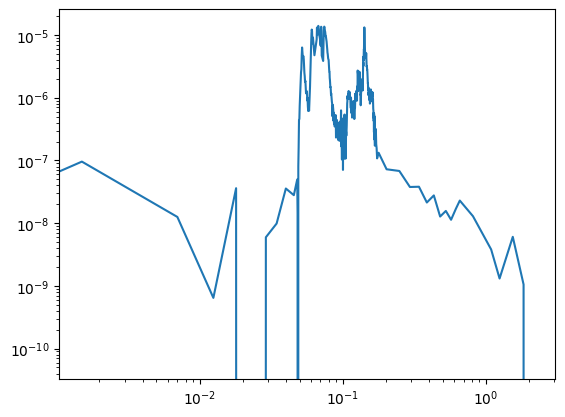

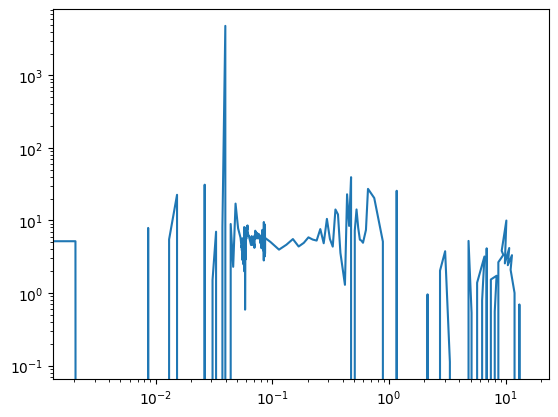

In [8]:
plt.figure()

!head picsit/grb221009a_afterglow_picsit_lc.txt

picsit_lc = pd.read_csv("picsit/grb221009a_afterglow_picsit_lc.txt", delim_whitespace=True, names=["mjd", "flux"])
picsit_hr = pd.read_csv("picsit/grb221009a_afterglow_picsit_hr.txt", delim_whitespace=True, names=["mjd", "hr"])
picsit_ag = pd.read_csv("picsit/grb221009a_picsit_prompt_afterglow_erg_230302.txt", delim_whitespace=True, names=["mjd", "flux", "flux_err"])


plt.plot(
    (picsit_ag.mjd - (T0_ijd + 51544))*24, 
    picsit_ag.flux, 
)

plt.loglog()

plt.figure()

plt.plot(
    (picsit_hr.mjd - (T0_ijd + 51544))*24, 
    picsit_hr.hr, 
)

plt.loglog()

In [9]:
import numpy as np
from rebin import rebin_in_bins


In [10]:
picsit_ag.sort_values('mjd', inplace=True)

# picsit_ag['flux_err'] = picsit_ag.flux*0 + 1e-8
picsit_ag['dt']  = np.concatenate([[0], np.array(picsit_ag['mjd'])[1:] - np.array(picsit_ag['mjd'])[:-1]])
picsit_ag['dt']

0      0.000000
1      0.000238
2      0.000229
3      0.000230
4      0.000231
         ...   
520    0.011530
521    0.006606
522    0.012333
523    0.012212
524    0.012244
Name: dt, Length: 525, dtype: float64

In [11]:
import subprocess
import io
import pathlib
from astropy.io import fits

def sshopen(fn):
    cfn = pathlib.Path("/tmp/sshopen-cache/") / fn.replace("/", "_")
    cfn.parent.mkdir(exist_ok=True)

    try:
        of = fits.open(cfn)
    except:
        f = io.BytesIO(subprocess.check_output(f"ssh login01.astro.unige.ch tar cf - {fn} | tar xf - -O", shell=True))

        with open(cfn, "wb") as F:
            F.write(f.read())
        
        of = fits.open(cfn)
    return of

sshopen("/isdc/arc/rev_3/scw/2558/255800290010.001/compton_events.fits.gz")


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f321493ab90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f3212a35cf0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f323b1d2950>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f323b1d25c0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f323b1d1f30>]

In [12]:

att_hist = None

for orbit in ["2558", "2559", "2560", "2561"]:
    _ = sshopen(f"/isdc/arc/rev_3/aux/adp/{orbit}.001/attitude_historic.fits.gz")[1].data
    if att_hist is None:
        att_hist = _
    else:
        att_hist = np.concatenate([att_hist, _])



scx = SkyCoord(att_hist['RA_SCX'], att_hist['DEC_SCX'], unit="deg")
scz = SkyCoord(att_hist['RA_SCZ'], att_hist['DEC_SCZ'], unit="deg")

theta = scx.separation(src_coord).deg


ijd2plot = lambda T: (T - T0_ijd)*24*3600
ijd2plot_d = lambda T: (T - T0_ijd)

# m_stable_ons_response = theta > 60
m_stable_ons_response = ijd2plot_d(att_hist['POINTING_TIME']) - att_hist['DURATION']/24/3600 < 0.1
m_stable_ons_response &= ijd2plot_d(att_hist['POINTING_TIME']) > -0.1




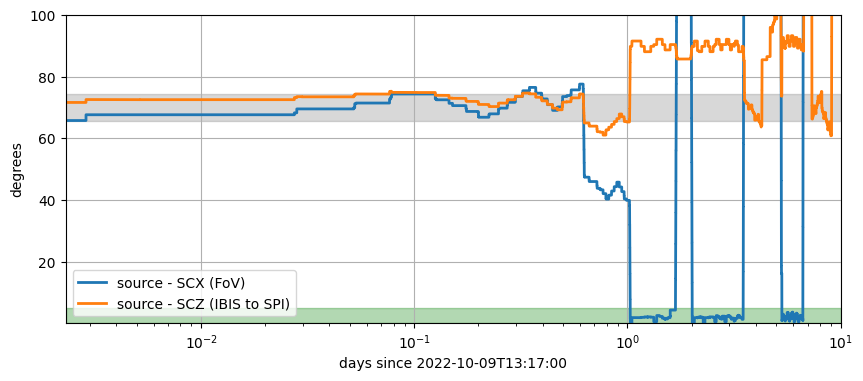

In [13]:

plt.figure(figsize=(10, 4))


def plot_obs():
    plt.step(
    # plt.scatter(
        ijd2plot_d(att_hist['TIME']),
        # att_hist['RA_SCX'],
        # att_hist['DEC_SCX']
        theta,
        where="pre",
        label="source - SCX (FoV)",
        lw=2
    )

    plt.step(
        ijd2plot_d(att_hist['TIME']),
        -1 * scz.separation(src_coord).deg + 180,
        label="source - SCZ (IBIS to SPI)",
        where='pre',
        lw=2
    )


    plt.axhspan(0, 5, color='green', alpha=0.3, 
                # label='< 5 deg, FoV observations with ISGRI and JEM-X'
                )
    # plt.axhspan(5, 10, color='yellow', alpha=0.3)

    plt.axhspan(theta[m_stable_ons_response].min(), theta[m_stable_ons_response].max(), color='grey', alpha=0.3,
                # label="range of relative source angles with stable all-sky response"
                )
    

    return m_stable_ons_response

plot_obs()

plt.xlim([200/24/3600, 10])
plt.ylim([0.1, 100])

# plt.loglog()
plt.semilogx()

plt.legend(loc='lower left')

plt.xlabel(f"days since {T0_isot}")
plt.ylabel(f"degrees")

plt.grid()

plt.savefig("relpos_history.pdf")

In [14]:
att_hist

array([(b'25580000', b'P', b'P', 0, 8316.73990954, 8316.73990954, 8316.73990954, 1.157035e+04, 0., 315.00226, -34.99975  , 210.64058, -19.506361, b'            ',   0.     , 0.       , 111.2, 0, nan,        nan,        nan),
       (b'25580001', b'O', b'M', 0, 8316.87382157, 8316.87894889, 8316.87465491, 0.000000e+00, 0., 316.01096, -36.77675  , 210.02783, -20.223055, b'            ',   0.     , 0.       , 111. , 0, nan,        nan,        nan),
       (b'25580001', b'O', b'M', 1, 8316.87382157, 8316.87894889, 8316.87512944, 0.000000e+00, 0., 316.89224, -38.214638 , 209.46721, -20.823944, b'            ',   0.     , 0.       , 111. , 0, nan,        nan,        nan),
       ...,
       (b'25610077', b'P', b'G', 0, 8327.24341648, 8327.24526833, 8327.26026833, 2.100000e+02, 0., 152.00063,   2.997611 , 241.2125 , -14.717639, b'0244-00053-1', 151.5325 , 2.4294446,  53. , 0, 0.3,  6.205e-04, -0.0023855),
       (b'25610077', b'P', b'G', 0, 8327.24341648, 8327.24526833, 8327.26269889, 2.69990

In [15]:
"""
obs1 (1-1.7 days, 8 rings):
 Model Flux 0.0014555 photons (1.0229e-11 ergs/cm^2/s) range (3.0000 - 10.000 keV)
 Model Flux 3.7829e-05 photons (7.6619e-13 ergs/cm^2/s) range (10.000 - 20.000 keV)
 Model Flux 3.359e-06 photons (1.455e-13 ergs/cm^2/s) range (20.000 - 100.00 keV)

obs2 (2-3.5 days, 4 rings):
 Model Flux 0.00027077 photons (1.8924e-12 ergs/cm^2/s) range (3.0000 - 10.000 keV)
 Model Flux 6.3803e-06 photons (1.2892e-13 ergs/cm^2/s) range (10.000 - 20.000 keV)
 Model Flux 5.4611e-07 photons (2.3622e-14 ergs/cm^2/s) range (20.000 - 100.00 keV)

obs3 (5.3-6.6 days, 2 rings):
 Model Flux 4.473e-05 photons (3.0338e-13 ergs/cm^2/s) range (3.0000 - 10.000 keV)
 Model Flux 7.8889e-07 photons (1.5892e-14 ergs/cm^2/s) range (10.000 - 20.000 keV)
 Model Flux 6.4597e-08 photons (2.7899e-15 ergs/cm^2/s) range (20.000 - 100.00 keV)
"""

rings = {
    'r2558': {
        'flux_ecs_3_10': 1.0229e-11,
        't1_since_t0_d': 1,
        't2_since_t0_d': 1.7,
    }
}

In [16]:
import ogip.core
import ogip.tools

import importlib

importlib.reload(ogip.tools)

from scipy.integrate import quad




def get_spectral_energy_density_for_one_count(instr, focus_obs_name='total_3p', e1=None, e2=None, pivot_energy_keV=50):
    model_generator = lambda p:(lambda x:(p[0]*(x/pivot_energy_keV)**-2))
    model = model_generator([1])
    conv_to_spectral_density = pivot_energy_keV**2 * u.keV.to(u.erg)

    if instr in ['JMX1', 'JMX2', 'IBIS']:
        # pha = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_spectrum_GRB221009A_{focus_obs_name}.fits")
        rmf = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_rmf_GRB221009A_{focus_obs_name}.fits")
        arf = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_arf_GRB221009A_{focus_obs_name}.fits")

        # fit_result, fitted_model = ogip.tools.fit(model_generator, [7e-5], [(pha, rmf, None, ~np.isnan(pha._rate))])

        if e1 is None:
            e1 = rmf._e_min.min()

        if e2 is None:
            e2 = rmf._e_max.max()

        m = rmf._e_min >= e1
        m &= rmf._e_max <= e2

        model_spec = ogip.tools.convolve(model, rmf, arf)

        print("model at pivot", pivot_energy_keV, model(pivot_energy_keV))
        print("counts in range", e1, e2, model_spec[m].sum())

        
        factor = model(pivot_energy_keV) / model_spec[m].sum() * conv_to_spectral_density
    elif instr == 'ACS':
        e1, e2 = 75, 2000
        flux_for_unitary_norm = quad(lambda x:model_generator([1])(x) * x * u.keV.to(u.erg), e1, e2)[0]

        print("flux_for_unitary_norm:", flux_for_unitary_norm)
        factor = 1e-10/flux_for_unitary_norm * conv_to_spectral_density
    elif instr == 'PICSIT':
        e1 = 250
        e2 = 2000
        factor = 2
    
    model_flux_in_range = quad(lambda x:model_generator([factor / conv_to_spectral_density])(x) * x * u.keV.to(u.erg), e1, e2)[0]

    print(f"\033[31m{factor} erg/cm2/s at {pivot_energy_keV}~keV for 1 count/s in {instr} {e1} - {e2} keV, model flux in range {model_flux_in_range}\033[0m")

    if instr == 'IBIS' and (e1, e2) == (28, 80):
        print("ibis crab", model_flux_in_range*200, 1e-8)
        assert np.abs((model_flux_in_range*200 - 1.2e-8)/1e-8) < 0.2

    return factor
    
    # flux = (fitted_model(rmf.c_energ) * rmf.d_energ * u.keV.to(u.erg))[(rmf.c_energ > e1) & (rmf.c_energ < e2)].sum() # erg/cm2/s/keV

    # print(e2.max() - e1.min())

    # return flux / model_spec.sum() # erg/cm2/s/keV for 1 count
    
    # factor =  fitted_model(e1) / model_spec * rmf.d_e * u.keV.to(u.erg)

    # # factor = ogip.tools.get_unfolding_factor(fitted_model, rmf, arf) * u.keV.to(u.erg) 

    # print("rate", np.nansum(pha._rate), "flux", np.nansum(pha._rate) * np.nanmean(factor))

    # # TODO: check more
    # return factor # erg/cm2 for single count


get_spectral_energy_density_for_one_count('IBIS', 'r2558', 28, 80)
get_spectral_energy_density_for_one_count('JMX2', 'r2558', 3, 20)
get_spectral_energy_density_for_one_count('ACS')
# get_spectral_energy_density_for_one_count('PICSIT')
# factor = get_spectral_energy_density_for_one_count('JMX1', 'r2558')


INFO:root:opened grbbase_fitspack_r2558/IBIS_rmf_GRB221009A_r2558.fits as <ogip.spec.RMF object at 0x7f31f457b1f0>
INFO:root:opened grbbase_fitspack_r2558/IBIS_arf_GRB221009A_r2558.fits as <ogip.spec.ARF object at 0x7f31f4a06740>
INFO:root:opened grbbase_fitspack_r2558/JMX2_rmf_GRB221009A_r2558.fits as <ogip.spec.RMF object at 0x7f31f46138b0>
INFO:root:opened grbbase_fitspack_r2558/JMX2_arf_GRB221009A_r2558.fits as <ogip.spec.ARF object at 0x7f31f4612950>


model at pivot 50 1.0
counts in range 28 80 67960.46
5.893782251835538e-11 erg/cm2/s at 50~keV for 1 count/s in IBIS 28 - 80 keV, model flux in range 6.187423004954584e-11
ibis crab 1.237484600990917e-08 1e-08
model at pivot 50 1.0
counts in range 3 20 36259.832
1.1046497903101064e-10 erg/cm2/s at 50~keV for 1 count/s in JMX2 3 - 20 keV, model flux in range 2.09565319349749e-10
flux_for_unitary_norm: 1.3151524370884477e-05
3.045610130083059e-11 erg/cm2/s at 50~keV for 1 count/s in ACS 75 - 2000 keV, model flux in range 1.0000002024336039e-10


3.045610130083059e-11

INFO:root:opened grbbase_fitspack_r2558/JMX1_spectrum_GRB221009A_r2558.fits as <ogip.spec.PHAI object at 0x7f3214aae2f0>
INFO:root:opened grbbase_fitspack_r2558/IBIS_spectrum_GRB221009A_r2558.fits as <ogip.spec.PHAI object at 0x7f31f4611b70>
INFO:root:opened grbbase_fitspack_total_3p/JMX1_rmf_GRB221009A_total_3p.fits as <ogip.spec.RMF object at 0x7f31f45afb50>
INFO:root:opened grbbase_fitspack_total_3p/JMX1_arf_GRB221009A_total_3p.fits as <ogip.spec.ARF object at 0x7f31f445b640>


model at pivot 50 1.0
counts in range 4 25 29277.941
1.3680748688652519e-10 erg/cm2/s at 50~keV for 1 count/s in JMX1 4 - 25 keV, model flux in range 2.507108645702443e-10


INFO:root:opened grbbase_fitspack_total_3p/IBIS_rmf_GRB221009A_total_3p.fits as <ogip.spec.RMF object at 0x7f32104d5c00>
INFO:root:opened grbbase_fitspack_total_3p/IBIS_arf_GRB221009A_total_3p.fits as <ogip.spec.ARF object at 0x7f32104f45b0>


model at pivot 50 1.0
counts in range 28 80 67960.46
5.893782251835538e-11 erg/cm2/s at 50~keV for 1 count/s in IBIS 28 - 80 keV, model flux in range 6.187423004954584e-11
ibis crab 1.237484600990917e-08 1e-08


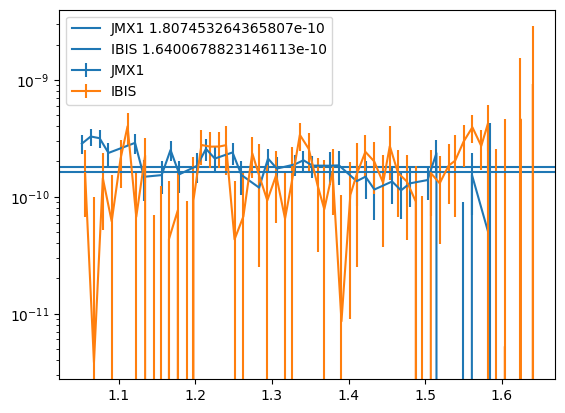

In [17]:
data = {
    'JMX1': 
        {
         'e1': 4,
         'e2': 25,
         'lc': fits.open(f"grbbase_fitspack_total_3p/JMX1_lc_GRB221009A.fits"),
         'pha': ogip.core.open_something(f"grbbase_fitspack_r2558/JMX1_spectrum_GRB221009A_r2558.fits")
        },
    'IBIS': 
        {
         'e1': 28,
         'e2': 80,
         'lc': fits.open(f"grbbase_fitspack_total_3p/IBIS_lc_GRB221009A.fits"),        
         'pha': ogip.core.open_something(f"grbbase_fitspack_r2558/IBIS_spectrum_GRB221009A_r2558.fits")
        }
    }

plt.figure()

for instr, d in data.items():
    factor = get_spectral_energy_density_for_one_count(instr, e1=d['e1'], e2=d['e2'])
    m = d['lc'][1].data['TIME'] < T0_ijd + 1.7

    plt.errorbar(
        d['lc'][1].data['TIME'][m] - T0_ijd,
        d['lc'][1].data['RATE'][m] * factor,
        d['lc'][1].data['ERROR'][m] * factor,
        label=instr
    )

    specrate = np.nansum(d['pha']._rate) * factor    

    plt.axhline(specrate, label=f"{instr} {specrate}")

plt.semilogy()

plt.legend()

In [18]:
m = np.array(picsit_ag.mjd)
m[1:][~((m[1:] - m[:-1]) > 0)]

array([], dtype=float64)

In [19]:
lc_by_instrument = {}

In [20]:
print("hklc:", list(hklc.keys()))

gedrate = hklc['/SPI_GEDRATE']
gedrate

m = gedrate.t < T0_ijd - 100./24/3600

resp = 2e8
gedrate['flux'] = (gedrate.c - np.mean(gedrate.c[m]))/resp
gedrate['flux_err'] = gedrate['flux']*0 + np.std(gedrate.c[m])/resp



hklc: ['/SPI_GEDRATE', '/SPI_GEDRATE0', '/SPI_GEDRATE1', '/SPI_GEDRATE10', '/SPI_GEDRATE11', '/SPI_GEDRATE12', '/SPI_GEDRATE13', '/SPI_GEDRATE14', '/SPI_GEDRATE15', '/SPI_GEDRATE16', '/SPI_GEDRATE17', '/SPI_GEDRATE18', '/SPI_GEDRATE2', '/SPI_GEDRATE3', '/SPI_GEDRATE4', '/SPI_GEDRATE5', '/SPI_GEDRATE6', '/SPI_GEDRATE7', '/SPI_GEDRATE8', '/SPI_GEDRATE9', '/SPI_GEDSAT', '/SPI_GEDSAT0', '/SPI_GEDSAT1', '/SPI_GEDSAT10', '/SPI_GEDSAT11', '/SPI_GEDSAT12', '/SPI_GEDSAT13', '/SPI_GEDSAT14', '/SPI_GEDSAT15', '/SPI_GEDSAT16', '/SPI_GEDSAT17', '/SPI_GEDSAT18', '/SPI_GEDSAT2', '/SPI_GEDSAT3', '/SPI_GEDSAT4', '/SPI_GEDSAT5', '/SPI_GEDSAT6', '/SPI_GEDSAT7', '/SPI_GEDSAT8', '/SPI_GEDSAT9', '/SPI_VETOGATE', '/SPI_VETONONSAT', '/SPI_VETOSAT']


In [21]:
# plt.figure()


# plt.errorbar(
#     ijd2plot(gedrate.t),
#     gedrate.flux,
#     gedrate.flux_err
# )
# plt.semilogy()

In [22]:
picsit_bti = pd.read_csv("picsit/grb221009a_bti_list.txt", delim_whitespace=True, names=["t1", "t2"])

for i, r in picsit_bti.iterrows():
    print(r.t1, r.t2)
    picsit_ag.flux[(picsit_ag.mjd > r.t1) & (picsit_ag.mjd < r.t2)] = np.NaN

59861.55557508222 59861.55559625096
59861.555623106426 59861.555623739376
59861.55602204203 59861.55626627378
59861.55643693712 59861.55656065312
59861.55714926659 59861.557170313834


In [23]:
from scipy.integrate import quad

def model_with_pars(x, p):    
    if len(p) == 1:
        return (10**p[0]*(x/25.)**-2)
    else:
        return (10**p[0]*(x/25.)**p[1])

lgN = -5 + np.log10(3.2878817582987386e-11/1e-11)    

quad(lambda x:model_with_pars(x, [lgN, -2])*x*u.keV.to(u.erg), 75, 2000)[0]

lgN

-4.483083809332035

9.999988000013202e-12 [9.999999999999994e-06]


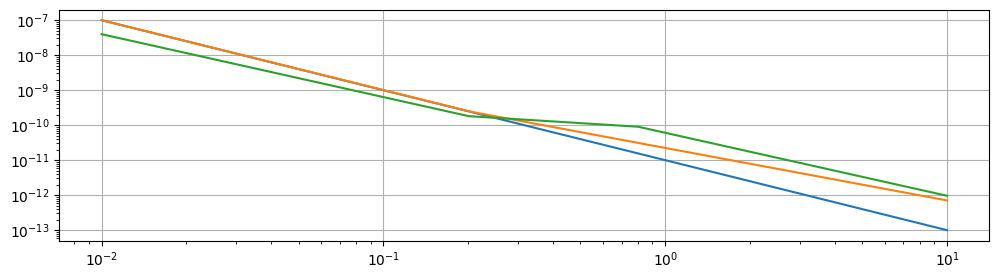

In [24]:
t_N = 1.

def conversion_for_instrument(i):
    return lc_by_instrument[i]['conversion_factor']

def s_t_model_gen(N, slope, t_break=np.NaN, slope_pb=np.NaN, t_break_er=np.NaN, slope_mid=np.NaN):

    def model(t, i):
        this_N = N
        this_slope = slope        

        if not np.isnan(t_break) and t > t_break:
            this_slope = slope_pb
            this_N -= np.log10(t_break) * (slope_pb - slope)
            if not np.isnan(t_break_er):
                this_N += np.log10(t_break) * (slope_mid - slope)    
                this_N -= np.log10(t_break_er) * (slope_mid - slope)
            
        if not np.isnan(t_break_er) and t_break_er < t < t_break:
            this_slope = slope_mid
            this_N -= np.log10(t_break_er) * (slope_mid - slope)
            
        if i is None:
            c = 1
        else:
            c = conversion_for_instrument(i)

        m = 10**this_N*(t/t_N)**this_slope/c
        
        # if t > 1 and t < 1.7:
        #     m += rings_flux_ecs_3_10_r2558
    
        return m
    
    # TODO: this is too slow
    return np.frompyfunc(model, 2, 1)    


print(s_t_model_gen(-11, -1.2)(1.000001, None), s_t_model_gen(-11, -1.2)(np.array([0.00001]), None))

plt.figure(figsize=(12, 3))

t = np.logspace(-2, 1, 1000)

plt.plot(t, s_t_model_gen(-11, -2)(t, None))
plt.plot(t, s_t_model_gen(-11, -2, 0.2, -1.5)(t, None))
plt.plot(t, s_t_model_gen(-11, -1.8, 0.8, -1.8, 0.2, -0.5)(t, None))
plt.loglog()
plt.grid()

/tmp/ipykernel_273399/780017232.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gedrate.flux[~m] = np.NaN
INFO:root:opened grbbase_fitspack_total_3p/IBIS_rmf_GRB221009A_total_3p.fits as <ogip.spec.RMF object at 0x7f323b1f90c0>
INFO:root:opened grbbase_fitspack_total_3p/IBIS_arf_GRB221009A_total_3p.fits as <ogip.spec.ARF object at 0x7f31f45781c0>
/home/savchenk/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/savchenk/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_273399/780017232.py:56: RuntimeWarning: invalid value encountered in scalar divide
  re = rebin_in_bins(d[

model at pivot 50 1.0
counts in range 28 80 67960.46
5.893782251835538e-11 erg/cm2/s at 50~keV for 1 count/s in IBIS 28 - 80 keV, model flux in range 6.187423004954584e-11
ibis crab 1.237484600990917e-08 1e-08
model at pivot 50 1.0
counts in range 4 29 29928.76
1.3383252818917316e-10 erg/cm2/s at 50~keV for 1 count/s in JMX1 4 - 29 keV, model flux in range 2.6512243492496454e-10
model at pivot 50 1.0
counts in range 4 29 30818.613
1.2996826133760223e-10 erg/cm2/s at 50~keV for 1 count/s in JMX2 4 - 29 keV, model flux in range 2.5746731661590764e-10
2 erg/cm2/s at 50~keV for 1 count/s in PICSIT 250 - 2000 keV, model flux in range 4.158883083359672
flux_for_unitary_norm: 1.3151524370884477e-05
3.045610130083059e-11 erg/cm2/s at 50~keV for 1 count/s in ACS 75 - 2000 keV, model flux in range 1.0000002024336039e-10


/tmp/ipykernel_273399/780017232.py:124: RuntimeWarning: invalid value encountered in scalar divide
  acs_C = 20*rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_mean, acs_T, agg=lambda x:(np.sum(x))/len(x))
/tmp/ipykernel_273399/780017232.py:125: RuntimeWarning: invalid value encountered in scalar divide
  acs_Cmin = 20*rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_max, acs_T, agg=lambda x:(np.sum(x))/len(x))
/tmp/ipykernel_273399/780017232.py:126: RuntimeWarning: invalid value encountered in scalar divide
  acs_Cmax = 20*rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_min, acs_T, agg=lambda x:(np.sum(x))/len(x))


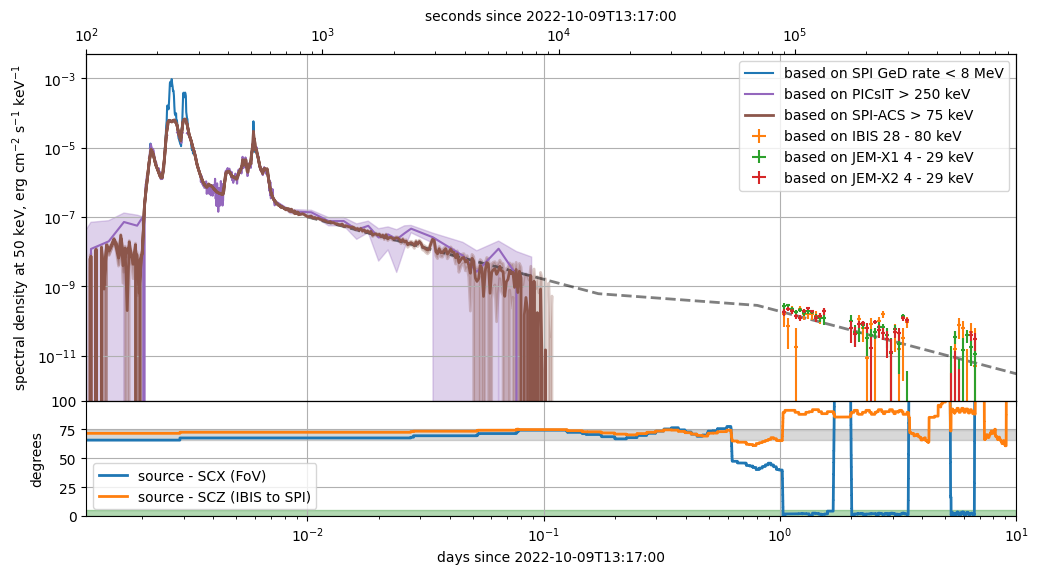

In [25]:
from astropy.io import fits
from rebin import rebin_in_bins, rebin_bins_in_bins


def plot_ag(models_to_plot):
    # utc http://www.stjarnhimlen.se/comp/time.html
    t_mjd_offset = 69.20/24/3600

    T = np.logspace(-1, 1, 120)
    Tc = (T[1:] + T[:-1])/2.
    dT = (T[1:] - T[:-1])/2.

    # plt.figure(figsize=(16, 6))
    f, axes = plt.subplots(2, 1, figsize=(12, 6), height_ratios=[3, 1], sharex=True)
    plt.sca(axes[0])

    ijd2plot = lambda t:(t- T0_ijd)

    # picked model
    # plt.plot(t, s_t_model_gen(-10.6, -1.8, 0.8, -1.8, 0.17, -0.5)(t, None), lw=2, color='k', alpha=0.5, ls="--")

    for model_to_plot, color in models_to_plot:
        plt.plot(t, model_to_plot(t, None), lw=2, color=color, alpha=0.5, ls="--")

    # plt.axhline(0, lw=2, c='k', alpha=0.5)


    m = ((_:=ijd2plot(gedrate.t - t_mjd_offset)) < 0.01) & (_ > 0.002)
    m &= gedrate.flux > 6e-6
    gedrate.flux[~m] = np.NaN

    plt.plot(
        ijd2plot(gedrate.t - t_mjd_offset),
        gedrate.flux,
        label='based on SPI GeD rate < 8 MeV'
    )

    for label, n in [('IBIS', 'IBIS'),
                    ('JEM-X1', 'JMX1'),
                    ('JEM-X2', 'JMX2')
                    ]:

        f = fits.open(f"grbbase_fitspack_total_3p/{n}_lc_GRB221009A.fits")

        e1 = int(f[1].header['E_MIN'])
        e2 = int(f[1].header['E_MAX'])

        d = f[1].data
        conversion_factor = get_spectral_energy_density_for_one_count(n, e1=e1, e2=e2)

        # plt.errorbar(ijd2plot(isgri_lc['TIME']), isgri_lc['RATE'], isgri_lc['ERROR'])

        d['RATE'][d['ERROR'] > np.nanmedian(d['ERROR'])*10] = np.NaN    

        r = rebin_in_bins(d['TIME'] - T0_ijd, d['RATE'], T)
        re = rebin_in_bins(d['TIME'] - T0_ijd, d['ERROR'], T, agg=lambda x:(np.sum(x**2))**0.5/len(x))

        m = re < np.nanmedian(re)*3

        # factor = 1e-8/200
        factor = conversion_factor

        plt.errorbar(
            Tc[m], 
            r[m]*factor,
            re[m]*factor,
            xerr=dT[m],
            label=f"based on {label} {e1:d} - {e2:d} keV",
            ls=""
        )

        lc_by_instrument[n] = {'t': Tc[m], 'r': r[m], 're': re[m], 'conversion_factor': conversion_factor}

    m = (picsit_ag.mjd - (T0_ijd + 51544)) < 0.1


    picsit_factor = get_spectral_energy_density_for_one_count('PICSIT')

    c = plt.plot(
    # c = plt.errorbar(
        (picsit_ag.mjd - (T0_ijd + 51544))[m], 
        picsit_ag.flux[m] * picsit_factor,
        # picsit_ag.flux_err[m],
        # xerr=picsit_ag.dt[m]/2,
        # ls="",
        label='based on PICsIT > 250 keV'
    )[0].get_color()

    plt.fill_between(
        (picsit_ag.mjd - (T0_ijd + 51544))[m], 
        (picsit_ag.flux[m] - picsit_ag.flux_err[m])*picsit_factor,
        (picsit_ag.flux[m] + picsit_ag.flux_err[m])*picsit_factor,
        # xerr=picsit_lc.dt[m]/2,
        # ls="",
        # label='PICsIT > 250 keV'
        alpha=0.3,
        color=c
    )


    lc_by_instrument['picsit'] = {'t': (picsit_ag.mjd - (T0_ijd + 51544))[m], 'r': picsit_ag.flux[m], 're': picsit_ag.flux_err[m], 'conversion_factor': 1}

    n = 1000

    def rebin(x, n):
        N = int(len(x)/n)
        return np.array(x[:N*n]).reshape((N, n)).sum(1)


    ## ACS
    # TODO: check values
    bkg = 5336.468053846153
    acs_cts_to_sp_density = get_spectral_energy_density_for_one_count('ACS')

    tail_change = 0.01
    tail_bins = np.logspace(-3, np.log10(0.11), 300)

    acs_T = np.concatenate([np.linspace(0, tail_change, int(tail_change/3*24*3600)), tail_bins])
    acs_Tc = (acs_T[1:] + acs_T[:-1])/2.
    acs_dT = (acs_T[1:] - acs_T[:-1])/2.



    acs_C = 20*rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_mean, acs_T, agg=lambda x:(np.sum(x))/len(x))
    acs_Cmin = 20*rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_max, acs_T, agg=lambda x:(np.sum(x))/len(x))
    acs_Cmax = 20*rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_min, acs_T, agg=lambda x:(np.sum(x))/len(x))

    c = None

    c = plt.plot(
        acs_Tc- t_mjd_offset,
        acs_C * acs_cts_to_sp_density,
        lw=2,
        label="based on SPI-ACS > 75 keV"
    )[0].get_color()


    c = plt.fill_between(
        acs_Tc - t_mjd_offset,
        acs_Cmin * acs_cts_to_sp_density,
        acs_Cmax * acs_cts_to_sp_density,
        lw=2,
        color=c,
        alpha=0.3
    )

    lc_by_instrument['acs'] = {'t': acs_Tc - t_mjd_offset, 'r': acs_C, 're': (acs_Cmax - acs_Cmin)/2, 'conversion_factor': acs_cts_to_sp_density}

    # TODO: picsit erange

    # plt.errorbar(
    #     (rings['r2558']['t1_since_t0_d'] + rings['r2558']['t2_since_t0_d'])/2.,
    #     rings['r2558']['flux_ecs_3_10'],
    #     rings['r2558']['flux_ecs_3_10']/2.,
    #     xerr=(rings['r2558']['t2_since_t0_d'] - rings['r2558']['t1_since_t0_d'])/2., 
    #     uplims=[True],
    #     lw=3,
    #     label="dust scattering rings, 3-10 keV"
    # )



    plt.ylim([0.5e-12, 5e-3])
    plt.ylabel("spectral density at 50 keV, erg cm$^{-2}$ s$^{-1}$ keV$^{-1}$")
    # plt.ylabel("spectral energy density at 50 keV, erg cm$^{-2}$ s$^{-1}$")
    # plt.ylabel("flux, erg cm$^{-2}$ s$^{-1}$ keV$^{-1}$")
    plt.loglog()
    # plt.grid()
    plt.legend()

    plt.sca(axes[1])

    m_stable_ons_response = plot_obs()

    plt.ylabel("degrees")
    plt.ylim([0, 100])
    plt.xlim([100./24/3600, 10])

    # plt.grid(which='both')
    # plt.grid()

    plt.legend(loc="lower left")

    plt.xlabel(f"days since {T0_isot}")

    plt.subplots_adjust(hspace=0)
    # plt.semilogx()

    plt.sca(axes[0])
    xl_d = plt.gca().get_xlim()

    ax = plt.twiny()
    ax.set_xlabel(f"seconds since {T0_isot}")
    plt.xlim(np.array(xl_d)*24*3600)
    plt.semilogx()


    plt.savefig("lc.png")
    plt.savefig("lc.pdf")

    # TODO: plot early AG SPI-ACS
    # TODO: plot model fitb
    # TODO: plot rings contribution approx


plot_ag([(s_t_model_gen(-10.6, -1.8, 0.8, -1.8, 0.17, -0.5), 'black')])


In [26]:
syst_by_instrument = {'acs': 0.3}

/tmp/ipykernel_273399/4222378380.py:28: RuntimeWarning: invalid value encountered in scalar power
  m = 10**this_N*(t/t_N)**this_slope/c
  0%|          | 0/30 [00:00<?, ?it/s]/home/savchenk/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 30/30 [00:01<00:00, 29.37it/s]


{'all_bpl2': {'p_best': [-10.577312431726467,
   -1.8040242815905962,
   0.84591603870966,
   -1.589353980495811,
   0.1529240381682374,
   -0.5178458109201878],
  'p_range': [array([-10.98965581, -10.27137024]),
   array([-1.90111921, -1.67831377]),
   array([0.73759659, 0.87420145]),
   array([-1.89280835, -1.60305826]),
   array([0.1549692 , 0.18244441]),
   array([-0.52920838, -0.46619579])],
  'sampler': <emcee.ensemble.EnsembleSampler at 0x7f3214a1f730>,
  'p_best_lnprob': -298.81004586912286,
  'ndof': 252,
  'chi2': 525.4710885440392},
 'all_bpl': {'p_best': [-10.19398413213833,
   -1.584610196459924,
   0.4566996463149811,
   -0.6090805959626171],
  'p_range': [array([-11.21893396,  -9.97324231]),
   array([-1.95331299, -1.47875253]),
   array([0.6394023 , 0.86622093]),
   array([-1.30657064, -1.01206445])],
  'sampler': <emcee.ensemble.EnsembleSampler at 0x7f31eff89600>,
  'p_best_lnprob': -479.55843279207534,
  'ndof': 252,
  'chi2': 886.9678623899442},
 'all_pl': {'p_best':

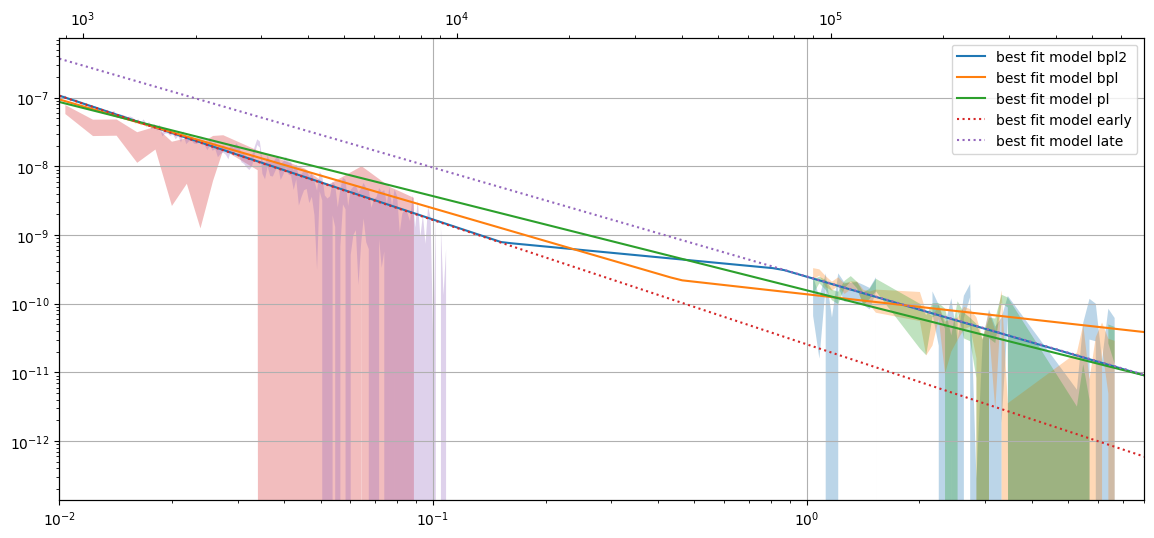

In [27]:
import numpy as np
import emcee
from scipy.stats import norm


plt.figure(figsize=(14, 6))


def fitit(ipick, p0_v = [np.log10(1e-11), -1.8], use_syst=False, nprocess=6):
    ndim, nwalkers = len(p0_v), 100
    p0_c = np.array([p0_v]*nwalkers)
    p0 = norm(p0_c, p0_c.__abs__()*0.05).rvs()

    def log_prior(p):
        if not (-12.5 < p[0] < -9.5):
            # print("p[0] out of bounds:", p[0])
            return -np.inf
        
        if not (-3 < p[1] < -0.5):
            # print("p[1] out of bounds:", p[1])
            return -np.inf

        if len(p) > 2 and not np.isnan(p[2]) and not (0.01 < p[2] < 5):
            # print("p[2] out of bounds:", p[2])
            return -np.inf
        
        # print("INBOUND p", p)

        return 0.0
            
    def log_prob(p, return_chi2=False):
        global ndof 

        mll = 0

        lp = log_prior(p)
        if not np.isfinite(lp):
            return -np.inf

        ndof = 0
        chi2 = 0

        for n, d in lc_by_instrument.items():
            # print(n)
            if ipick(n):
            # if n in ['JMX1', 'JMX2', 'IBIS', 'picsit']:
                model = s_t_model_gen(*p)(d['t'], n)

                sigma2 = np.array(d['re']**2)
                
                if use_syst:
                    sigma2 = sigma2 + model*syst_by_instrument.get(n, 0)
                    # print("using syst:", n, syst_by_instrument.get(n, 0))


                m = d['t'] > 1000./24/3600

                try:
                    m &= ~np.isinf(sigma2) & ~np.isnan(sigma2)
                except:
                    pass
                    # print("can not compute isinf:", n, "ignoring")
                
                dev = ((model - d['r'])**2/sigma2)[m]
                
                c_mll = -0.5 * dev.sum() + np.log(sigma2[m].mean())

                # c_mll = norm(model, d['re']).logpdf(d['r']) #.sum()

                # print(p, 'model', s_t_model_gen(*p)(1, n), c_mll)
                # print(n, c_mll.sum(), "d['re']:", dev.sum())

                chi2 += dev.sum()
                ndof += len(dev)
                
                mll += c_mll.sum()

        if np.isnan(mll):
            # print("this returns Inf:", p, mll)
            return -np.inf
        
        # print("this returns:", p, mll, lp)
        if return_chi2:
            return chi2, ndof
        else:
            return mll + lp

    from multiprocessing.pool import ThreadPool as Pool

    # with Pool(nprocess) as pool:
    # with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob) #, pool=pool)

    sampler.run_mcmc(p0, nsampler, progress=True)

    p_best = [r[np.argmax(sampler.flatlnprobability)] for r in sampler.flatchain.transpose()]
    p_best_lnprob = sampler.flatlnprobability.transpose().max()
    p_range = [np.percentile(r, [5, 95]) for r in sampler.flatchain.transpose()]

    f = sampler.flatlnprobability
    assert(len(f[~np.isinf(f)])) > 0

    chi2, ndof = log_prob(p_best, return_chi2=True)

    return {'p_best': p_best, 'p_range': p_range, 'sampler': sampler, 'p_best_lnprob': p_best_lnprob, 'ndof': ndof, 'chi2': chi2}


T = np.logspace(-2, 1, 100)

# plt.plot(T, s_t_model_gen(np.log10(1.3e-11), -1.8, 0.8, -1.2, 0.2, -1.2)(T, 'picsit'), label="best guess model")

ag_fit = {}

models_to_plot = []

r = fitit(lambda n: True, p0_v = [-10.6, -1.8, 0.8, -1.8, 0.17, -0.5])
ag_fit['all_bpl2'] = r
plt.plot(T, s_t_model_gen(*ag_fit['all_bpl2']['p_best'])(T, 'picsit'), label=f"best fit model bpl2")
models_to_plot.append(lambda t, i:s_t_model_gen(*ag_fit['all_bpl2']['p_best'])(t, i))

r = fitit(lambda n: True, p0_v = [np.log10(1.3e-11), -1.8, 0.8, -1.2])
ag_fit['all_bpl'] = r
plt.plot(T, s_t_model_gen(*ag_fit['all_bpl']['p_best'])(T, 'picsit'), label="best fit model bpl")
models_to_plot.append(lambda t, i:s_t_model_gen(*ag_fit['all_bpl']['p_best'])(t, i))

r = fitit(lambda n: True, p0_v = [-10.2, -1.3], use_syst=True)
ag_fit['all_pl'] = r
plt.plot(T, s_t_model_gen(*ag_fit['all_pl']['p_best'])(T, 'picsit'), label="best fit model pl")
models_to_plot.append(lambda t, i:s_t_model_gen(*ag_fit['all_pl']['p_best'])(t, i))


r = fitit(lambda n: n in ['acs', 'picsit'], use_syst=True)
ag_fit['acs_picsit'] = r
plt.plot(T, s_t_model_gen(*ag_fit['acs_picsit']['p_best'])(T, 'picsit'), label="best fit model early", ls=":")
models_to_plot.append(lambda t, i:s_t_model_gen(*ag_fit['acs_picsit'])(t, i))


# r = fitit(lambda n: n in ['IBIS'])
r = fitit(lambda n: n in ['JMX1', 'JMX2', 'IBIS'])
ag_fit['jmx_ibis'] = r
plt.plot(T, s_t_model_gen(*ag_fit['jmx_ibis']['p_best'])(T, 'picsit'), label="best fit model late", ls=":")
models_to_plot.append(lambda t, i:s_t_model_gen(*ag_fit['jmx_ibis']['p_best'])(t, i))


plt.legend()

for n, d in lc_by_instrument.items():
    m = d['t'] > 0.01
    plt.fill_between(d['t'][m], 
                     (d['r'] - d['re'])[m] * conversion_for_instrument(n),
                     (d['r'] + d['re'])[m] * conversion_for_instrument(n), alpha=0.3)

plt.loglog()
plt.xlim([1e-2, 8])

# plt.grid()

xl_d = plt.gca().get_xlim()

plt.twiny()
plt.xlim(np.array(xl_d)*24*3600)
plt.semilogx()


plt.savefig("st_models.pdf")
plt.savefig("st_models.png")

# TODO: separate fits for two sections with a break
# TODO: make spectral real
# TODO: make steps with fill
ag_fit

[]

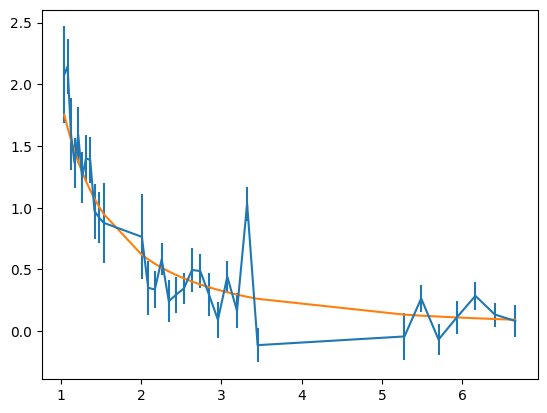

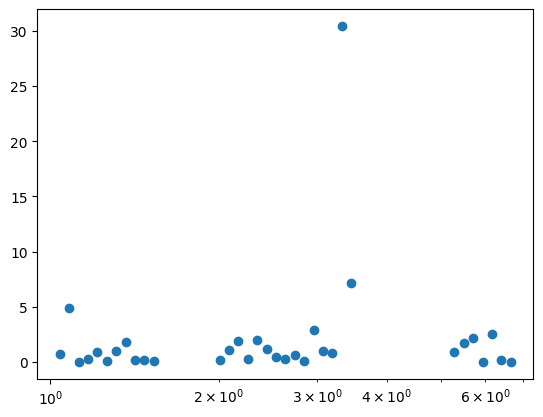

In [28]:
plt.figure()

i = 'JMX1'

c = conversion_for_instrument('picsit')

plt.errorbar(
    lc_by_instrument[i]['t'],
    lc_by_instrument[i]['r'],
    lc_by_instrument[i]['re']
)

model = s_t_model_gen(*ag_fit['jmx_ibis']['p_best'])(lc_by_instrument[i]['t'], i)

plt.plot(
    lc_by_instrument[i]['t'],
    model
)

# plt.loglog()
# plt.xlim([1,1.5])

plt.figure()

plt.scatter(
    lc_by_instrument[i]['t'],
    ((lc_by_instrument[i]['r'] - model) / lc_by_instrument[i]['re'])**2,
)


(((lc_by_instrument[i]['r'] - model) / lc_by_instrument[i]['re'])**2).mean()

plt.semilogx()
# plt.xlim([1,1.5])

In [29]:
ag_fit

{'all_bpl2': {'p_best': [-10.577312431726467,
   -1.8040242815905962,
   0.84591603870966,
   -1.589353980495811,
   0.1529240381682374,
   -0.5178458109201878],
  'p_range': [array([-10.98965581, -10.27137024]),
   array([-1.90111921, -1.67831377]),
   array([0.73759659, 0.87420145]),
   array([-1.89280835, -1.60305826]),
   array([0.1549692 , 0.18244441]),
   array([-0.52920838, -0.46619579])],
  'sampler': <emcee.ensemble.EnsembleSampler at 0x7f3214a1f730>,
  'p_best_lnprob': -298.81004586912286,
  'ndof': 252,
  'chi2': 525.4710885440392},
 'all_bpl': {'p_best': [-10.19398413213833,
   -1.584610196459924,
   0.4566996463149811,
   -0.6090805959626171],
  'p_range': [array([-11.21893396,  -9.97324231]),
   array([-1.95331299, -1.47875253]),
   array([0.6394023 , 0.86622093]),
   array([-1.30657064, -1.01206445])],
  'sampler': <emcee.ensemble.EnsembleSampler at 0x7f31eff89600>,
  'p_best_lnprob': -479.55843279207534,
  'ndof': 252,
  'chi2': 886.9678623899442},
 'all_pl': {'p_best':

/tmp/ipykernel_273399/780017232.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gedrate.flux[~m] = np.NaN
INFO:root:opened grbbase_fitspack_total_3p/IBIS_rmf_GRB221009A_total_3p.fits as <ogip.spec.RMF object at 0x7f31f4267670>
INFO:root:opened grbbase_fitspack_total_3p/IBIS_arf_GRB221009A_total_3p.fits as <ogip.spec.ARF object at 0x7f31f43042e0>
/home/savchenk/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/savchenk/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_273399/780017232.py:56: RuntimeWarning: invalid value encountered in scalar divide
  re = rebin_in_bins(d[

model at pivot 50 1.0
counts in range 28 80 67960.46
5.893782251835538e-11 erg/cm2/s at 50~keV for 1 count/s in IBIS 28 - 80 keV, model flux in range 6.187423004954584e-11
ibis crab 1.237484600990917e-08 1e-08
model at pivot 50 1.0
counts in range 4 29 29928.76
1.3383252818917316e-10 erg/cm2/s at 50~keV for 1 count/s in JMX1 4 - 29 keV, model flux in range 2.6512243492496454e-10
model at pivot 50 1.0
counts in range 4 29 30818.613
1.2996826133760223e-10 erg/cm2/s at 50~keV for 1 count/s in JMX2 4 - 29 keV, model flux in range 2.5746731661590764e-10
2 erg/cm2/s at 50~keV for 1 count/s in PICSIT 250 - 2000 keV, model flux in range 4.158883083359672
flux_for_unitary_norm: 1.3151524370884477e-05
3.045610130083059e-11 erg/cm2/s at 50~keV for 1 count/s in ACS 75 - 2000 keV, model flux in range 1.0000002024336039e-10


/tmp/ipykernel_273399/780017232.py:124: RuntimeWarning: invalid value encountered in scalar divide
  acs_C = 20*rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_mean, acs_T, agg=lambda x:(np.sum(x))/len(x))
/tmp/ipykernel_273399/780017232.py:125: RuntimeWarning: invalid value encountered in scalar divide
  acs_Cmin = 20*rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_max, acs_T, agg=lambda x:(np.sum(x))/len(x))
/tmp/ipykernel_273399/780017232.py:126: RuntimeWarning: invalid value encountered in scalar divide
  acs_Cmax = 20*rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_min, acs_T, agg=lambda x:(np.sum(x))/len(x))


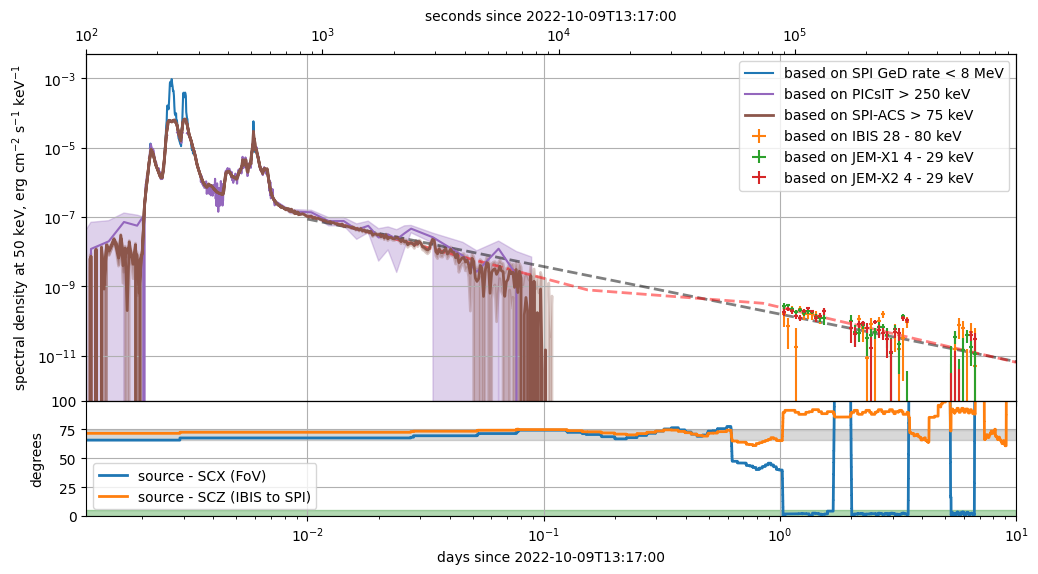

In [30]:
plot_ag([(models_to_plot[2], 'black'), (models_to_plot[0], 'red')])

corner failed!
corner failed!
corner failed!
corner failed!
corner failed!


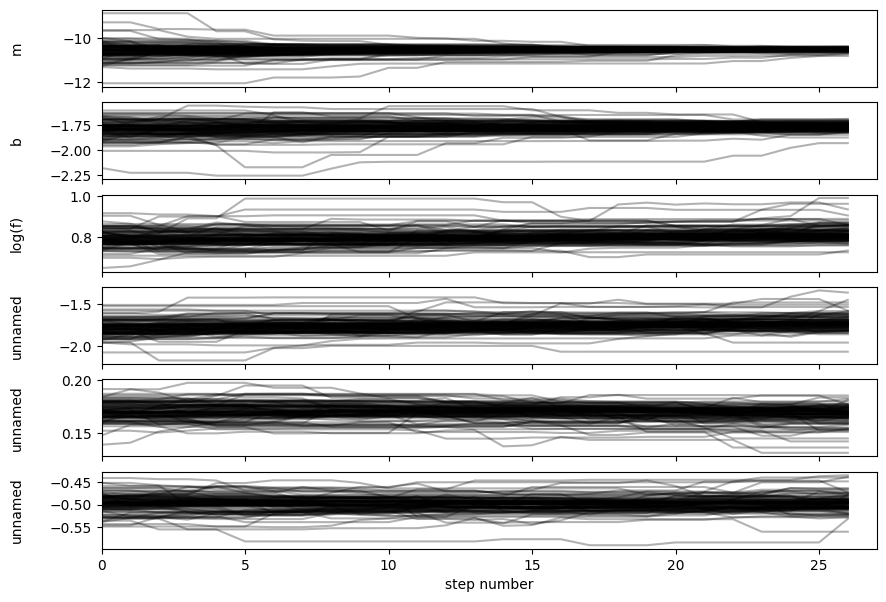

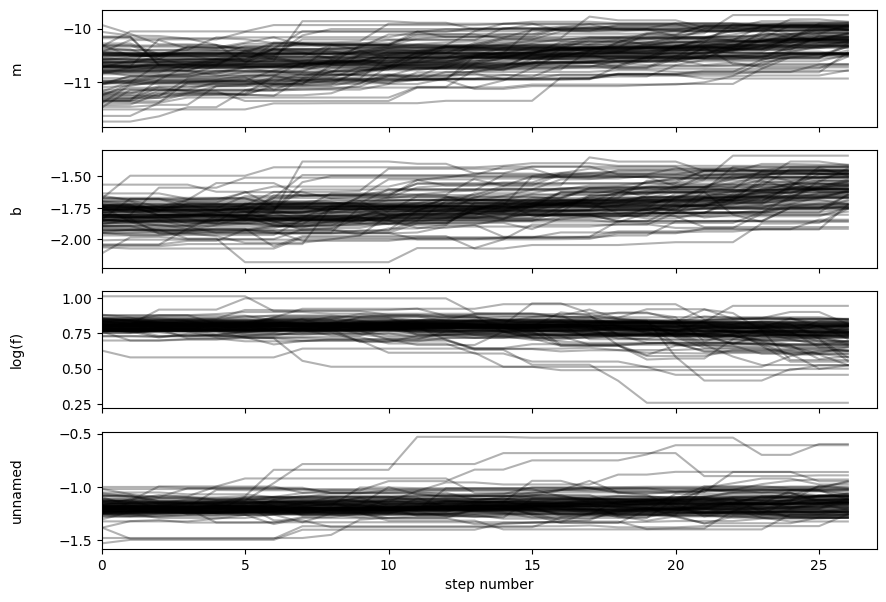

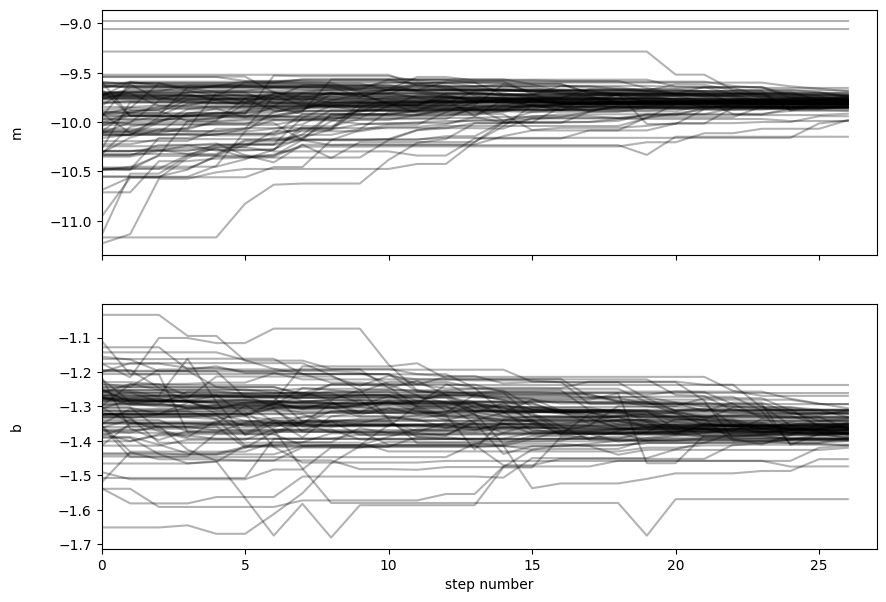

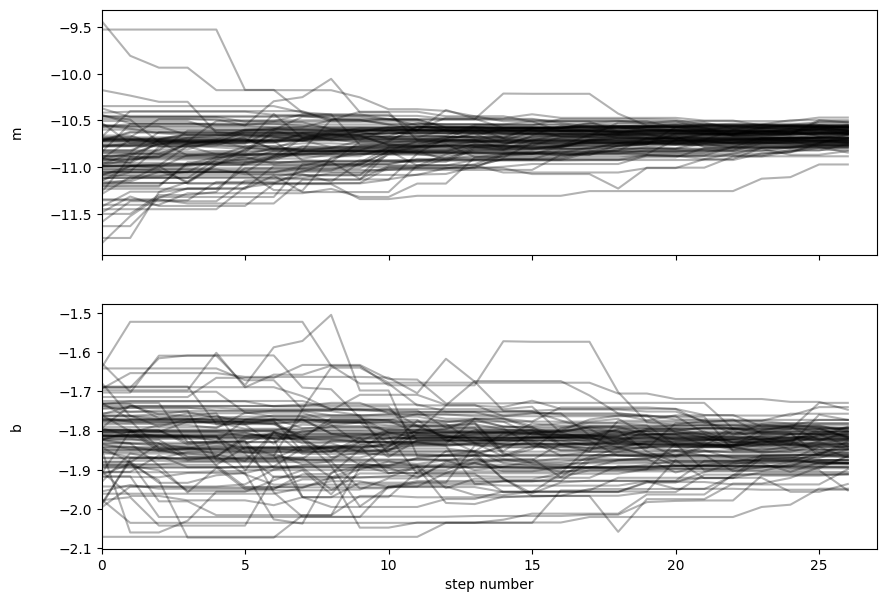

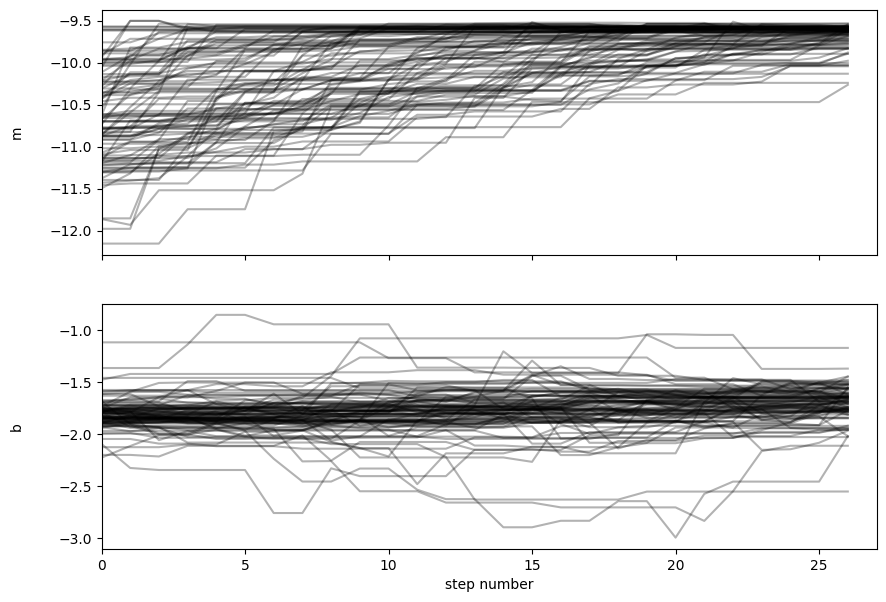

In [31]:
if nsampler > 1000:
    ndiscard = 200
else:
    ndiscard = nsampler//10

emcee_pdfs = []

for n in ag_fit:

    sampler= ag_fit[n]['sampler']
    ndim = ag_fit[n]['sampler'].ndim

    import corner

    samples = sampler.get_chain(flat=False, discard=ndiscard)
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

    # _=plt.hist(samples[:, 0], 100, color="k", histtype="step")
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    labels = ["m", "b", "log(f)"] + ["unnamed"] * 10
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.savefig(f"chain_{n}.pdf")
    emcee_pdfs.append(f"chain_{n}.pdf")

    try:
        _ = corner.corner(flat_samples)
        plt.savefig(f"corner_{n}.pdf")
        emcee_pdfs.append(f"corner_{n}.pdf")
    except Exception:
        print("corner failed!")


    # plt.xlabel(r"$\theta_1$")
    # plt.ylabel(r"$p(\theta_1)$")
    # plt.gca().set_yticks([]);

In [32]:
emcee_pdfs

['chain_all_bpl2.pdf',
 'chain_all_bpl.pdf',
 'chain_all_pl.pdf',
 'chain_acs_picsit.pdf',
 'chain_jmx_ibis.pdf']

In [33]:
for nm, m in ag_fit.items():
    pnames = ["N", "slope"]

    m.pop('sampler', None)

    if nm == "all_bpl":
        pnames += ["t_br", "slope_pb"]

    elif nm == "all_bpl2":
        pnames += ["t_br", "slope_pb", "t_br_er", "slope_mid"]

    for n, p, pr in zip(pnames, m['p_best'], m['p_range']):
        print(nm, n, p, pr)

        if p < pr[0] or p > pr[1]:
            p = (pr[0] + pr[1])/2.

        m[n] = {
            'mean': p,
            'stat_err_minus': p - pr[0],
            'stat_err_plus': pr[1] - p
        }

ag_fit

all_bpl2 N -10.577312431726467 [-10.98965581 -10.27137024]
all_bpl2 slope -1.8040242815905962 [-1.90111921 -1.67831377]
all_bpl2 t_br 0.84591603870966 [0.73759659 0.87420145]
all_bpl2 slope_pb -1.589353980495811 [-1.89280835 -1.60305826]
all_bpl2 t_br_er 0.1529240381682374 [0.1549692  0.18244441]
all_bpl2 slope_mid -0.5178458109201878 [-0.52920838 -0.46619579]
all_bpl N -10.19398413213833 [-11.21893396  -9.97324231]
all_bpl slope -1.584610196459924 [-1.95331299 -1.47875253]
all_bpl t_br 0.4566996463149811 [0.6394023  0.86622093]
all_bpl slope_pb -0.6090805959626171 [-1.30657064 -1.01206445]
all_pl N -9.804259524537146 [-10.3422712   -9.57075297]
all_pl slope -1.3712129129422035 [-1.45789034 -1.20622142]
acs_picsit N -10.590921719381546 [-11.23244497 -10.48110844]
acs_picsit slope -1.8099655656322537 [-1.96665025 -1.70886626]
jmx_ibis N -9.602860667514552 [-11.19938676  -9.56791443]
jmx_ibis slope -1.5857265418831303 [-2.08156118 -1.48319423]


{'all_bpl2': {'p_best': [-10.577312431726467,
   -1.8040242815905962,
   0.84591603870966,
   -1.589353980495811,
   0.1529240381682374,
   -0.5178458109201878],
  'p_range': [array([-10.98965581, -10.27137024]),
   array([-1.90111921, -1.67831377]),
   array([0.73759659, 0.87420145]),
   array([-1.89280835, -1.60305826]),
   array([0.1549692 , 0.18244441]),
   array([-0.52920838, -0.46619579])],
  'p_best_lnprob': -298.81004586912286,
  'ndof': 252,
  'chi2': 525.4710885440392,
  'N': {'mean': -10.577312431726467,
   'stat_err_minus': 0.41234338162411355,
   'stat_err_plus': 0.30594219035242887},
  'slope': {'mean': -1.8040242815905962,
   'stat_err_minus': 0.09709493156193871,
   'stat_err_plus': 0.1257105163287784},
  't_br': {'mean': 0.84591603870966,
   'stat_err_minus': 0.10831944797344939,
   'stat_err_plus': 0.028285414496585726},
  'slope_pb': {'mean': -1.747933302115057,
   'stat_err_minus': 0.14487504437905607,
   'stat_err_plus': 0.14487504437905607},
  't_br_er': {'mean': 

In [34]:
lc_pdf = "lc.pdf"
rings = rings
relpos_history_pdf = "relpos_history.pdf"
st_models_pdf = "st_models.pdf"
comment_reconstruction = "assuming slope of -2"
theta_ons_min = theta[m_stable_ons_response].min()
theta_ons_max = theta[m_stable_ons_response].max()
approx_ons_t1_isot = Time(att_hist['POINTING_TIME'][m_stable_ons_response].min() + 51544, format='mjd').isot
approx_ons_t1_rel_d = att_hist['POINTING_TIME'][m_stable_ons_response].min() - T0_ijd
approx_ons_t2_isot = Time(att_hist['POINTING_TIME'][m_stable_ons_response].max() + 51544, format='mjd').isot
approx_ons_t2_rel_d = att_hist['POINTING_TIME'][m_stable_ons_response].max() - T0_ijd
ons_response_change_pc = 30 # check
pivot_energy = 50
ag_fit = ag_fit